<a href="https://colab.research.google.com/github/subikkshas/PREPARE-ALL/blob/main/misc_works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
from google.colab import drive
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

## Load data

In [2]:
drive.mount('/content/drive')

# Define the path to the folder in Google Drive
drive_folder_path = '/content/drive/MyDrive/NIR dataset'

# Load the data files
X_Train = pd.read_csv(os.path.join(drive_folder_path, 'X_train_encoded.csv'))
y_Train = pd.read_csv(os.path.join(drive_folder_path, 'y_train_encoded.csv'))
X_Test = pd.read_csv(os.path.join(drive_folder_path, 'X_test_encoded.csv'))
y_Test = pd.read_csv(os.path.join(drive_folder_path, 'y_test_encoded.csv'))

print("Data loaded successfully!")

Mounted at /content/drive
Data loaded successfully!


## Male & Female Relapsed cases

In [3]:
X_combined = pd.concat([X_Train, X_Test], ignore_index=True)
y_combined = pd.concat([y_Train, y_Test], ignore_index=True)

print("Combined X shape:", X_combined.shape)
print("Combined y shape:", y_combined.shape)

Combined X shape: (2252, 26)
Combined y shape: (2252, 1)


In [4]:
# Combine train and test data for analysis
combined_data = pd.concat([X_combined, y_combined], axis=1)

# Group by 'Sex' and 'Relapsed' and count the occurrences
relapsed_by_sex = combined_data.groupby(['Sex', 'Relapsed']).size().unstack(fill_value=0)

# Display the results
print("Number of relapsed cases by Sex:")
display(relapsed_by_sex)

Number of relapsed cases by Sex:


Relapsed,0,1
Sex,,
0,1047,403
1,640,162


In [5]:
# Calculate the percentage of relapsed cases for each sex category
relapsed_percentage_by_sex = relapsed_by_sex.apply(lambda x: x / x.sum(), axis=1) * 100

# Display the results
print("\nPercentage of relapsed cases by Sex:")
display(relapsed_percentage_by_sex)


Percentage of relapsed cases by Sex:


Relapsed,0,1
Sex,,
0,72.206897,27.793103
1,79.800499,20.199501


## XGBoost model

### Load model

In [14]:
import joblib
import os

best_threshold = 0.437

# Define the path to the model file in Google Drive
model_file_path = os.path.join(drive_folder_path, 'xgb_model.joblib')

# Load the model
xgb_model = joblib.load(model_file_path)

print("XGBoost model loaded successfully!")

XGBoost model loaded successfully!


### Feature importance

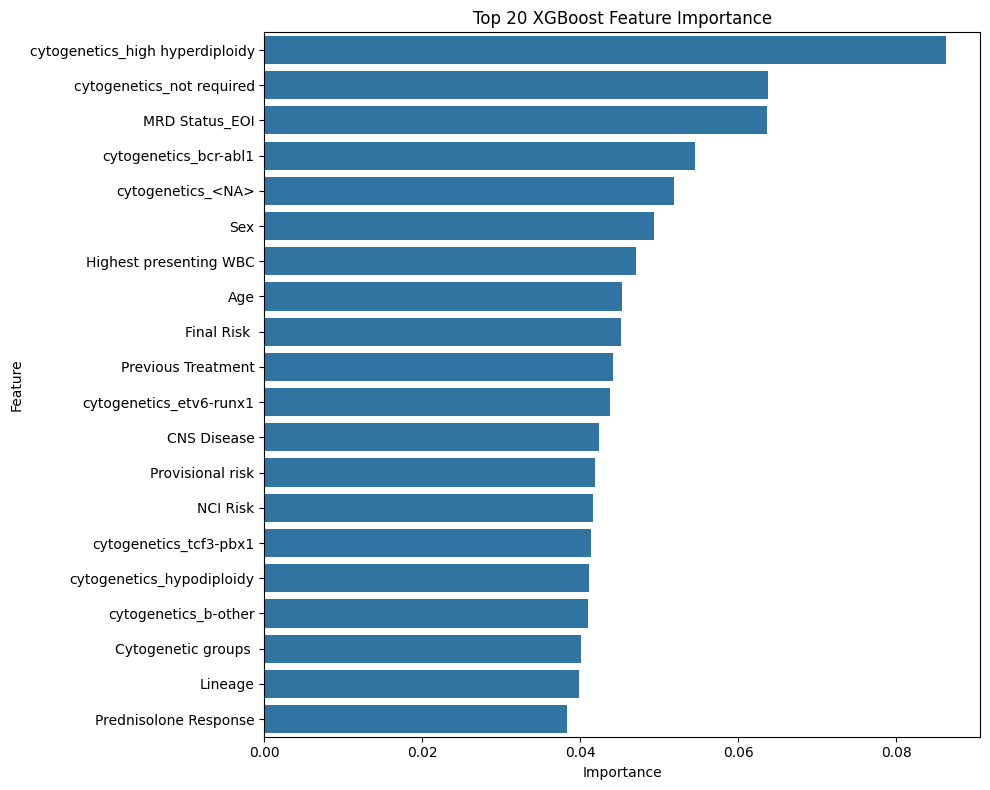

Top 15 feature importance plot saved to /content/drive/MyDrive/NIR dataset/feature_importance.svg


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Get feature importances from the trained XGBoost model
feature_importances = xgb_model.feature_importances_

# Create a pandas Series for easier handling
feature_importance_series = pd.Series(feature_importances, index=X_Train.columns)

# Sort feature importances in descending order
sorted_feature_importance = feature_importance_series.sort_values(ascending=False)

# Select the top 15 features
top_15_features = sorted_feature_importance.head(20)

# Plot the top 15 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=top_15_features.values, y=top_15_features.index)
plt.title('Top 20 XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

# Define the path to save the plot in Google Drive
plot_save_path = os.path.join(drive_folder_path, 'feature_importance.svg')

# Save the plot as SVG
plt.savefig(plot_save_path, format='svg')

plt.show()

print(f"Top 15 feature importance plot saved to {plot_save_path}")

### SHAP

In [18]:
!pip install shap

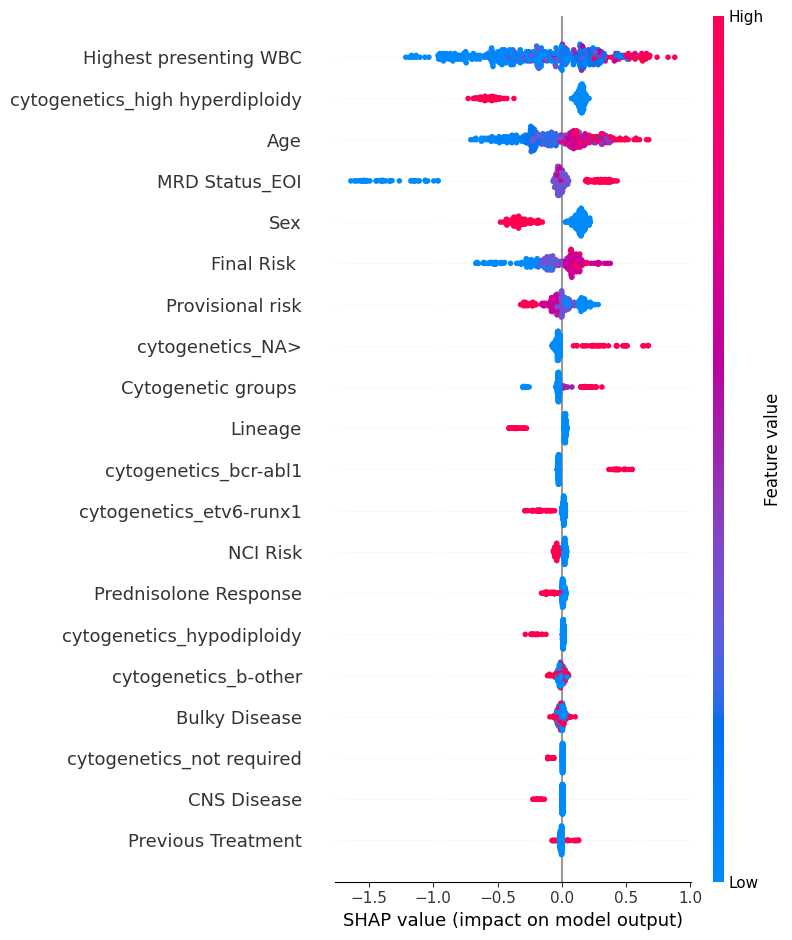

SHAP summary plot saved to /content/drive/MyDrive/NIR dataset/shap_summary_plot.svg


In [19]:
import shap
import re

# Function to clean column names
def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        new_col = re.sub(r'\[|\]|<', '', col)  # Remove [, ], and < characters
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# Clean column names of X_Test
X_Test_cleaned = clean_col_names(X_Test.copy())


# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_Test_cleaned)

# Generate a SHAP summary plot
shap.summary_plot(shap_values, X_Test_cleaned, show=False)

# Define the path to save the plot in Google Drive
plot_save_path = os.path.join(drive_folder_path, 'shap_summary_plot.svg')

# Save the plot as SVG
plt.savefig(plot_save_path, format='svg')

plt.show()

print(f"SHAP summary plot saved to {plot_save_path}")

## XGBoost - Risk wise predictions

In [9]:
# Predict probabilities
y_prob = xgb_model.predict_proba(X_Test)[:, 1]   # prob for positive class

# Apply threshold to get binary predictions
y_pred = (y_prob >= best_threshold).astype(int)


In [10]:
# Make sure Final Risk is available
test_with_risk = X_Test.copy()
test_with_risk['y_true'] = y_Test
test_with_risk['y_pred'] = y_pred
test_with_risk['y_prob'] = y_prob


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

category_metrics = {}

for cat in sorted(test_with_risk['Final Risk '].unique()):
    subset = test_with_risk[test_with_risk['Final Risk '] == cat]
    if len(subset) > 0:
        category_metrics[cat] = {
            'count': len(subset),
            'accuracy': accuracy_score(subset['y_true'], subset['y_pred']),
            'precision': precision_score(subset['y_true'], subset['y_pred'], zero_division=0),
            'recall': recall_score(subset['y_true'], subset['y_pred'], zero_division=0),
            'f1': f1_score(subset['y_true'], subset['y_pred'], zero_division=0),
            'auc': roc_auc_score(subset['y_true'], subset['y_prob'])
        }

import pandas as pd
metrics_df = pd.DataFrame(category_metrics).T
print(metrics_df)


   count  accuracy  precision    recall        f1       auc
0  118.0  0.669492   0.225000  0.529412  0.315789  0.681712
1  116.0  0.439655   0.209677  0.448276  0.285714  0.473246
2  181.0  0.535912   0.388430  0.824561  0.528090  0.645869
3   32.0  0.562500   0.350000  0.875000  0.500000  0.625000


In [12]:
from sklearn.metrics import confusion_matrix

for cat in sorted(test_with_risk['Final Risk '].unique()):
    subset = test_with_risk[test_with_risk['Final Risk '] == cat]
    cm = confusion_matrix(subset['y_true'], subset['y_pred'])
    print(f"Category {cat} confusion matrix:\n{cm}\n")


Category 0 confusion matrix:
[[70 31]
 [ 8  9]]

Category 1 confusion matrix:
[[38 49]
 [16 13]]

Category 2 confusion matrix:
[[50 74]
 [10 47]]

Category 3 confusion matrix:
[[11 13]
 [ 1  7]]

